# Studying phase transitions using dimensional reduction

This code relies on work from Lauren Hayward, Juan Carrasquilla, and Mohamed Hibat Allah. Dataset generated using Monte Carlo sampling. <br>
Reference: https://arxiv.org/abs/1606.00318

The objective of this notebook is to use the dimensional reduction techniques to identify phases without knowledge of phase labels. Dimensional reduction methods aim to generate a lower-dimensional representation $\mathcal{D}′ = \{x′\}$ of a high-dimensional dataset $\mathcal{D} = \{x\}$, where $x′ \in \mathbb{R}^{N′}$, $x \in \mathbb{R}^{N}$ and $N′ < N$. The lower-dimensional dataset should still encode the important features of the original higher-dimensional data.

### Import libraries

In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython import display
import numpy.linalg as la

import warnings
warnings.filterwarnings("ignore")

### Load data

($x$ is used to refer to the spin configurations).

In [2]:
github_dir = 'https://raw.githubusercontent.com/sofiagonga/ML_manybody_physics/main/dimensional_reduction_phase_transitions/data'

#Ising model
x_ising_20_url = os.path.join(github_dir, 'spinConfigs_Ising_L20.txt') #configurations
x_ising_40_url = os.path.join(github_dir, 'spinConfigs_Ising_L40.txt') #configurations
x_ising_80_url = os.path.join(github_dir, 'spinConfigs_Ising_L80.txt') #configurations

x_ising_20 = np.loadtxt(x_ising_20_url , dtype='int16')
x_ising_40 = np.loadtxt(x_ising_40_url , dtype='int16')
x_ising_80 = np.loadtxt(x_ising_80_url , dtype='int16')

T_ising_20_url = os.path.join(github_dir, 'temperatures_Ising_L20.txt') #configurations
T_ising_40_url = os.path.join(github_dir, 'temperatures_Ising_L40.txt') #configurations
T_ising_80_url = os.path.join(github_dir, 'temperatures_Ising_L80.txt') #configurations

T_ising_20 = np.loadtxt(T_ising_20_url , dtype='double')
T_ising_40 = np.loadtxt(T_ising_40_url , dtype='double')
T_ising_80 = np.loadtxt(T_ising_80_url , dtype='double')

#Gauge theory model
x_gauge_20_url = os.path.join(github_dir, 'spinConfigs_gaugeTheory_L20.txt') #configurations
x_gauge_40_url = os.path.join(github_dir, 'spinConfigs_gaugeTheory_L40.txt') #configurations
x_gauge_80_url = os.path.join(github_dir, 'spinConfigs_gaugeTheory_L80.txt') #configurations

x_gauge_20 = np.loadtxt(x_gauge_20_url , dtype='int16')
x_gauge_40 = np.loadtxt(x_gauge_40_url , dtype='int16')
x_gauge_80 = np.loadtxt(x_gauge_80_url , dtype='int16')

y_gauge_20_url = os.path.join(github_dir, 'labels_gaugeTheory_L20.txt') #labels
y_gauge_40_url = os.path.join(github_dir, 'labels_gaugeTheory_L40.txt') #labels
y_gauge_80_url = os.path.join(github_dir, 'labels_gaugeTheory_L80.txt') #labels

y_gauge_20 = np.loadtxt(y_gauge_20_url , dtype='double')
y_gauge_40 = np.loadtxt(y_gauge_40_url , dtype='double')
y_gauge_80 = np.loadtxt(y_gauge_80_url , dtype='double')

Store system sizes and print as check:

In [6]:
n_configs_ising_20 = x_ising_20.shape[0]
n_spins_ising_20 = x_ising_20.shape[1]
L_ising_20 = int(np.sqrt(n_spins_ising_20))

n_configs_ising_40 = x_ising_40.shape[0]
n_spins_ising_40 = x_ising_40.shape[1]
L_ising_40 = int(np.sqrt(n_spins_ising_40))

n_configs_ising_80 = x_ising_80.shape[0]
n_spins_ising_80 = x_ising_80.shape[1]
L_ising_80 = int(np.sqrt(n_spins_ising_80))

print("Ising model system sizes: ", L_ising_20, L_ising_40, L_ising_80)

Ising model system sizes:  20 40 80


In [5]:
n_configs_gauge_20 = x_gauge_20.shape[0]
n_spins_gauge_20 = x_gauge_20.shape[1]
L_gauge_20 = int(np.sqrt(n_spins_gauge_20/2))

n_configs_gauge_40 = x_gauge_40.shape[0]
n_spins_gauge_40 = x_gauge_40.shape[1]
L_gauge_40 = int(np.sqrt(n_spins_gauge_40/2))

n_configs_gauge_80 = x_gauge_80.shape[0]
n_spins_gauge_80 = x_gauge_80.shape[1]
L_gauge_80 = int(np.sqrt(n_spins_gauge_80/2))

print("Ising model system sizes: ", L_gauge_20, L_gauge_40, L_gauge_80)

Ising model system sizes:  20 40 80


## Define functions

Plotting functions:

In [ ]:
def plot_pca_scatter(X_prime, sys_size, columns = [0,1]):
    plt.title('Ising model PCA (L = ' + str(sys_size) + ')')
    plt.scatter(X_prime[:,columns[0]], X_prime[:,columns[1]], s = 3, c = "#458B74")
    plt.xlabel(r'$x$' + str(columns[0]+1))
    plt.ylabel(r'$x$' + str(columns[1]+1))
    plt.show()

def plot_pca_scatter_with_T(X_prime, temperatures, sys_size, columns = [0,1]):
    plt.title('Ising model PCA with temperature (L = ' + str(sys_size) + ')')
    plt.scatter(X_prime[:,columns[0]], X_prime[:,columns[1]], s = 5, c = temperatures, cmap = 'coolwarm')
    plt.xlabel(r'$x$' + str(columns[0]+1))
    plt.ylabel(r'$x$' + str(columns[1]+1))
    plt.colorbar(label="temperature", orientation="vertical")
    plt.figure(figsize=(15, 6))
    plt.show()
    
def plot_evr_comparison(evr_arrays, sys_sizes):
    plt.yscale("log")  
    title = 'Top '+ str(len(evr_arrays[0])) + ' explained variance ratios $r_l$'
    plt.title(title)
    for i in range(len(evr_arrays)):
        plt.plot(evr_arrays[i], ls = '--', marker = '.', label = r'$L$ = ' + str(sys_sizes[i]))
    plt.legend()
    plt.show()

def plot_P_column(P, column_index):
    title = 'Components of ' + str(column_index + 1) + r'th column of $P$ matrix'
    plt.title(title)
    plt.plot(np.abs(P[:,column_index]) - np.mean(np.abs(P[:,column_index])), lw = 0.9, c = "#458B74")
    ylabel = '$\mid p\mid$' +  str(column_index+1)
    plt.ylabel(ylabel)
    plt.xlabel('Component Index')
    plt.show()

Calcuations:

In [ ]:
def X_c(x, M):
    X_c = x - (1/M)*np.outer(np.ones(M).T, np.sum(x, axis=0))
    return X_c

def X_prime(X_c):
    lambdas, P = la.eig(np.dot(X_c.T, X_c))
    X_prime = np.dot(X_c, P)
    return X_prime, lambdas, P

## 1. Principal component analysis (PCA)

The principal component analysis (PCA) method performs dimensional reduction by applying a linear transformation. In this problem you we apply PCA to $N$-dimensional spin configurations of the two- dimensional Ising model and Ising gauge theory.

### <span style="color:brown"> **Ising model** </span>

### 1.1. Obtaining the principal components

PCA can be performed on a matrix $X_C$ where each column has mean 0. One can calculate $X_C$ from $x$ as: $X_{ij}^C = X_{ij} - \frac{1}{M}\sum_{k=1}^M X_{kj}$. The principal components $x′_1, x′_2,...$ are then stored in the columns of an $M \times N$ matrix: $X' = X_C P$. $P$ is determined by solving the eigenvalue problem: $\frac{1}{M-1}X_C^TX_C = P^T D P$ where $D$ is a diagonal matrix with non-negative entries $\lambda_1 \geq \lambda_2 \geq  ... \geq  \lambda_N \geq  0$.

In [123]:
Xc_20 = X_c(x = x_ising_20, M = n_configs_ising_20)
Xc_40 = X_c(x = x_ising_40, M = n_configs_ising_40)
Xc_80 = X_c(x = x_ising_80, M = n_configs_ising_80)

X_prime_20, lambdas_20, P_20 = X_prime(Xc_20)
X_prime_40, lambdas_40, P_40 = X_prime(Xc_40)
X_prime_80, lambdas_80, P_80 = X_prime(Xc_80)

Project the samples in the space spanned by the first two (leading) principal components.

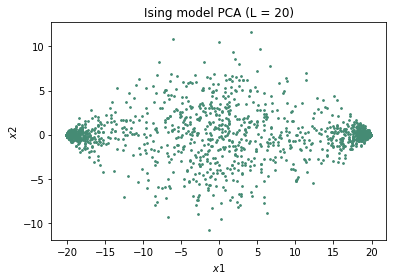

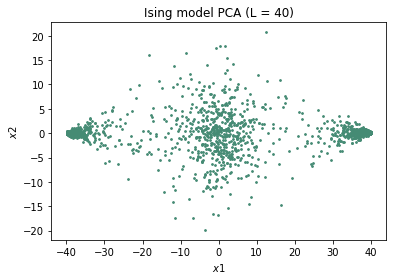

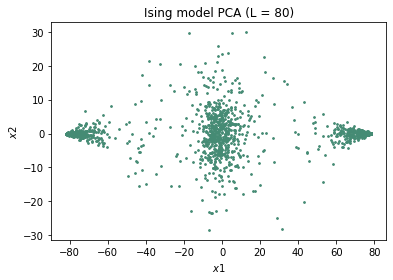

In [94]:
plot_pca_scatter(X_prime_20, sys_size = 20, columns = [0,1])
plot_pca_scatter(X_prime_40, sys_size = 40, columns = [0,1])
plot_pca_scatter(X_prime_80, sys_size = 80, columns = [0,1])

With larger $L$ we observe increasing clustering of the scattering of the PCA elements. We observe a split into three clusters.

Label with temperature:

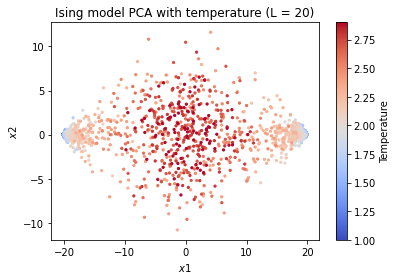

<Figure size 1080x432 with 0 Axes>

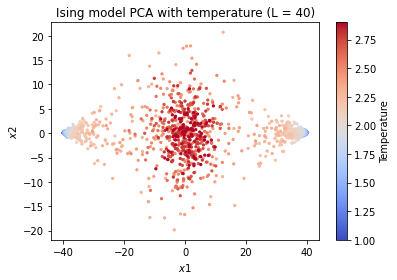

<Figure size 1080x432 with 0 Axes>

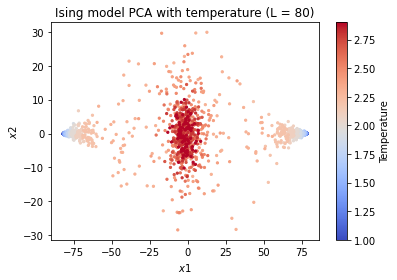

<Figure size 1080x432 with 0 Axes>

In [95]:
plot_pca_scatter_with_T(X_prime_20, temperatures = T_ising_20, sys_size = 20, columns = [0,1])
plot_pca_scatter_with_T(X_prime_40, temperatures = T_ising_40, sys_size = 40, columns = [0,1])
plot_pca_scatter_with_T(X_prime_80, temperatures = T_ising_80, sys_size = 80, columns = [0,1])

Scattered points around the origin correspond to high-temperature samples, while on the left and right of this centre scattering we find the low temperature points, corresponding to the two distinct ground states of the Ising model (symmetric and opposite polarisations). The sample points in between these two phases correspond to the critical temperature points, where we observe large fluctuations in the PCA plots.

### 1.2. Explained variance ratios, $r_l$

Another important definition is the so-called explained variance ratio $r_l$, which measures how much of the variance in the dataset $x$ can be explained by the principal component $x′_l$. This ratio is defined in
terms of the eigenvalues $\lambda_l$ as: $r_l = \frac{\lambda_l}{\sum_{i+1}^N \lambda_{i}}$.

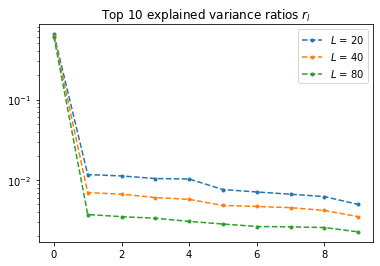

In [121]:
rl_20 = lambdas_20 / np.sum(lambdas_20)
rl_20_max_to_min = np.sort(rl_20)[::-1] #Choose top 10 largest
rl_20_top_10 = rl_20_max_to_min[0:10]

rl_40 = lambdas_40 / np.sum(lambdas_40)
rl_40_max_to_min = np.sort(rl_40)[::-1] #Choose top 10 largest
rl_40_top_10 = rl_40_max_to_min[0:10]

rl_80 = lambdas_80 / np.sum(lambdas_80)
rl_80_max_to_min = np.sort(rl_80)[::-1] #Choose top 10 largest
rl_80_top_10 = rl_80_max_to_min[0:10]

#plot r_l comparison
plot_evr_comparison([rl_20_top_10, rl_40_top_10, rl_80_top_10], [20,40,80])

We observe one single dominant principal component, which is the one needed to explain how the Ising spin configurations vary as a function of temperature.

### 1.3. Plotting components of $P$ matrix

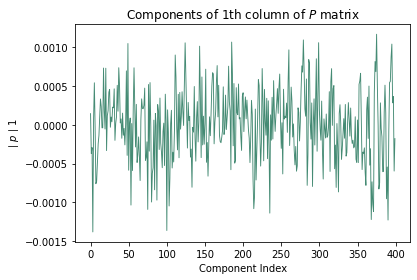

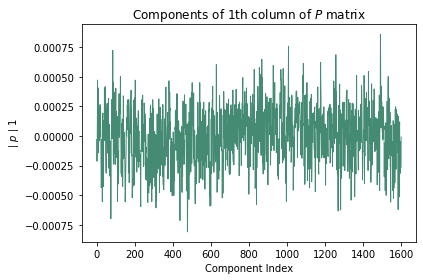

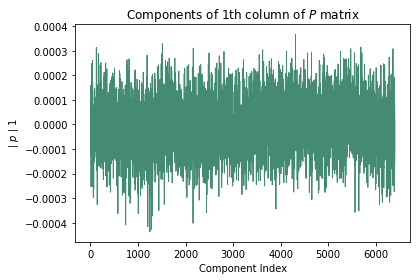

In [132]:
column_index = 0
plot_P_column(P_20, column_index)
plot_P_column(P_40, column_index)
plot_P_column(P_80, column_index)

We observe a flat distribution around a constant value all over the lattice sites, which means the transformation actually gives uniform magnetization. Therefore, this method has identified the order parameter of the Ising model, magnetisation. This constant behaviour seems to be more recognisable with increasing system size, potentially due to finite size effects.

### <span style="color:brown"> **Ising gauge theory** </span>

### 1.1. Obtaining the principal components

In [134]:
Xc_gauge_20 = X_c(x = x_gauge_20, M = n_configs_gauge_20)
Xc_gauge_40 = X_c(x = x_gauge_40, M = n_configs_gauge_40)
Xc_gauge_80 = X_c(x = x_gauge_80, M = n_configs_gauge_80)

X_prime_gauge_20, lambdas_gauge_20, P_gauge_20 = X_prime(Xc_gauge_20)
X_prime_gauge_40, lambdas_gauge_40, P_gauge_40 = X_prime(Xc_gauge_40)
X_prime_gauge_80, lambdas_gauge_80, P_gauge_80 = X_prime(Xc_gauge_80)

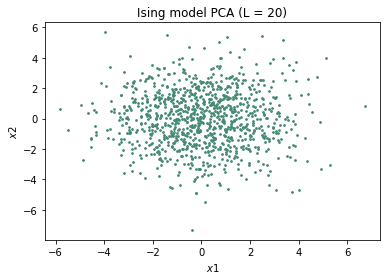

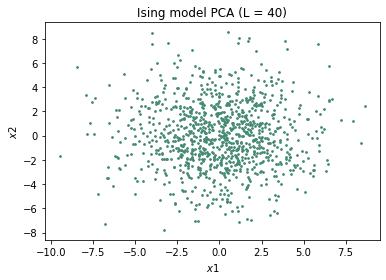

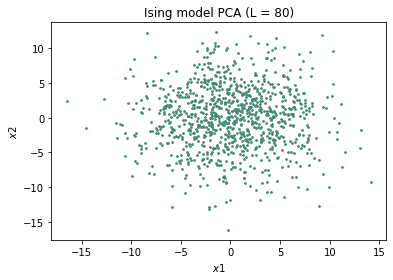

In [135]:
plot_pca_scatter(X_prime_gauge_20, sys_size = 20, columns = [0,1])
plot_pca_scatter(X_prime_gauge_40, sys_size = 40, columns = [0,1])
plot_pca_scatter(X_prime_gauge_80, sys_size = 80, columns = [0,1])

Unlike in Ising model, we don't see any distinct clear phases (clusters).

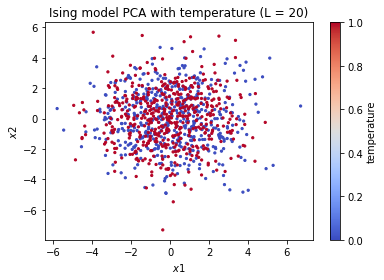

<Figure size 1080x432 with 0 Axes>

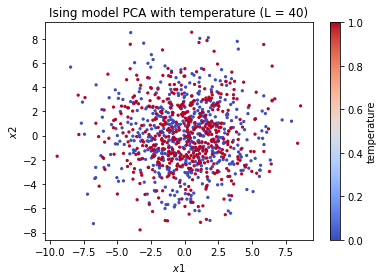

<Figure size 1080x432 with 0 Axes>

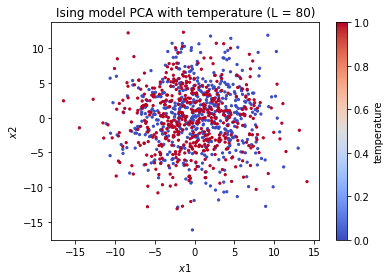

<Figure size 1080x432 with 0 Axes>

In [145]:
plot_pca_scatter_with_T(X_prime_gauge_20, temperatures = y_gauge_20, sys_size = 20, columns = [0,1])
plot_pca_scatter_with_T(X_prime_gauge_40, temperatures = y_gauge_40, sys_size = 40, columns = [0,1])
plot_pca_scatter_with_T(X_prime_gauge_80, temperatures = y_gauge_80, sys_size = 80, columns = [0,1])

### 1.2. Explained variance ratios, $r_l$

In [146]:
lambdas_gauge_20 = lambdas__gauge_20
lambdas_gauge_40 = lambdas__gauge_40
lambdas_gauge_80 = lambdas__gauge_80

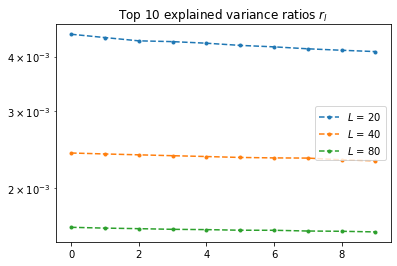

In [147]:
rl_gauge_20 = lambdas_gauge_20 / np.sum(lambdas_gauge_20)
rl_gauge_20_max_to_min = np.sort(rl_gauge_20)[::-1] #Choose top 10 largest
rl_gauge_20_top_10 = rl_gauge_20_max_to_min[0:10]

rl_gauge_40 = lambdas_gauge_40 / np.sum(lambdas_gauge_40)
rl_gauge_40_max_to_min = np.sort(rl_gauge_40)[::-1] #Choose top 10 largest
rl_gauge_40_top_10 = rl_gauge_40_max_to_min[0:10]

rl_gauge_80 = lambdas_gauge_80 / np.sum(lambdas_gauge_80)
rl_gauge_80_max_to_min = np.sort(rl_gauge_80)[::-1] #Choose top 10 largest
rl_gauge_80_top_10 = rl_gauge_80_max_to_min[0:10]

#plot r_l comparison
plot_evr_comparison([rl_gauge_20_top_10, rl_gauge_40_top_10, rl_gauge_80_top_10], [20,40,80])

PCA is not succesful for the Ising gauge theory, we don't find any distinct clusters or any leading components in the explained variance ratio.

With dimensional reduction we aim to get information about structures or order (e.g: phases) in our system which we don't know. Therefore, the data is not labelled (this is what we are trying to explore) and this constitutes and unsupervised learning task.

## 2. Identifying phase transitions using $t$-SNE

- $X$: matrix which contains the dataset. 
- *no_dims*: number of dimensions you want the t-SNE procedure to reduce the dimensionality of $X$ to.
- *initial_dims*: intial dimensionality of $X$.
- *perplexity*: measures the effective number of neighbours.